In [24]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr

import dask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

# **Water Permamency**


Import required DC utils

In [26]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter

Define aoi via wkt polygon (could be subbed or shapefile)

In [27]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [28]:
#set baseline start and end of period
start_date = '2019-1-1'
end_date = '2019-12-1'
res = (30)

In [29]:
dc = datacube.Datacube(app="water permamency")

In [30]:
dask_chunks=dict(
    x=1000,
    y=1000
)

In [31]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [32]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [33]:
#create resolution
resolution = (-res, res)

In [34]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

### Load Data

Generic query specs

In [35]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = baseline_time_period,
                resolution = resolution,
                group_by = 'solar_day',
                dask_chunks = dask_chunks
            )


Dataset-specifics

In [36]:
dsL8 = dc.load(product='ls8_water_classification',
               measurements = ["water"],
               **query)

In [37]:
dsL7 = dc.load(product='ls7_water_classification',
                measurements = ["water"],
               **query)

In [38]:
dsL5 = dc.load(product='ls5_water_classification',
                measurements = ["water"],
               **query)

In [39]:
dsL4 = dc.load(product='ls4_water_classification',
                measurements = ["water"],
               **query)

In [40]:
dsS1 = dc.load(product='s1g_gamma0_scene',
              **query)

In [41]:
print(dsS1)

<xarray.Dataset>
Dimensions:             (time: 54, x: 339, y: 336)
Coordinates:
  * time                (time) datetime64[ns] 2019-01-03T17:40:16 ... 2019-11-30T06:40:08
  * y                   (y) float64 8.038e+06 8.038e+06 ... 8.028e+06 8.028e+06
  * x                   (x) float64 5.361e+05 5.361e+05 ... 5.462e+05 5.463e+05
Data variables:
    vh                  (time, y, x) float32 dask.array<shape=(54, 336, 339), chunksize=(1, 336, 339)>
    vv                  (time, y, x) float32 dask.array<shape=(54, 336, 339), chunksize=(1, 336, 339)>
    layovershadow_mask  (time, y, x) float32 dask.array<shape=(54, 336, 339), chunksize=(1, 336, 339)>
Attributes:
    crs:      EPSG:32760


In [42]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [43]:
waterL8 = dsL8.where(dsL8 != -9999)
waterL7 = dsL7.where(dsL7 != -9999)
waterL5 = dsL5.where(dsL5 != -9999)
waterL4 = dsL4.where(dsL4 != -9999)

In [44]:
dsS2 = dc.load(product='s2_esa_sr_granule',
               platform = 'SENTINEL_2',
                  measurements = ["blue", "green","red","nir","swir1","swir2", "scene_classification"],
                  **query)

In [45]:
def createS1water (ds_s1):
    #s1_coverage = masking.mask_invalid_data(ds)
    #s1_coverage_clean = s1_coverage.where(s1_coverage!=0)
    # save the nodata mask as Lee filter doesn't consider nan
    #nodata_mask = s1_coverage_clean.isnull().to_array().any(axis=0)
    #replace nan with 0
    #ds_s1_filled = s1_coverage.where(~s1_coverage.isnull(), 0)
    ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)
    
    ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
    ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)
    #smoothed=smoothed.where(~nodata_mask)
    #clean=smoothed.copy()
    #clean['vv'] =clean.vv.where(~clean.vv.isnull(), 1000)
    #clean['vh'] =clean.vh.where(~clean.vh.isnull(), 1000)
    #clean['vv'] =clean.vv.where(clean.vv>0, 1e-3)
    #clean['vh'] =clean.vh.where(clean.vh>0, 1e-4)
    #clean=clean.where(clean<1000)
    vv_threshold = 12
    vh_threshold = -20.0
    ds_s1['water'] = ((ds_s1["filtered_vv"] <= vv_threshold) & (ds_s1["filtered_vh"] <= vh_threshold))
    ds_s1_ready = xr.Dataset.drop(ds_s1, labels = ["vh", "vv", "layovershadow_mask"])
    #s1_water = s1_coverage['water']
    return ds_s1_ready

In [46]:
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter
if is_dataset_empty(dsS1):
    print('no S1 images for this time and area')
else:
    s1water = dask.delayed(createS1water(dsS1))
    s1water_comp = s1water.compute()
    

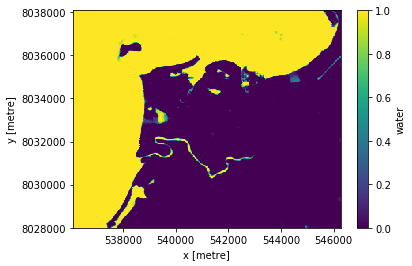

In [47]:
s1water_comp.water.mean(dim = 'time').plot();

In [48]:
#s1_coverage.wofs.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [49]:
if is_dataset_empty(dsS2):
    print('invalid')
else:
    good_quality = (
            (dsS2.scene_classification != 0) & # mask out NO_DATA
            (dsS2.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (dsS2.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (dsS2.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (dsS2.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (dsS2.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (dsS2.scene_classification != 10)&  # mask out THIN_CIRRUS
            (dsS2.scene_classification != 11)  # mask out SNOW
        )
    water_classes = dask.delayed(wofs_classify)(dsS2, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    waterS2 = dask.delayed(water_classes.rename({'wofs': 'water'}))
    waterS2_comp = waterS2.compute()
    

In [50]:
waterL8_comp = waterL8.compute()
waterL7_comp = waterL7.compute()
waterL5_comp = waterL5.compute()
waterL4_comp = waterL4.compute()

In [51]:
print(waterL8_comp)

<xarray.Dataset>
Dimensions:  (time: 35, x: 339, y: 336)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-04T22:12:40 ... 2019-09-03T22:00:39
  * y        (y) float64 8.038e+06 8.038e+06 8.038e+06 ... 8.028e+06 8.028e+06
  * x        (x) float64 5.361e+05 5.361e+05 5.362e+05 ... 5.462e+05 5.463e+05
Data variables:
    water    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760


In [27]:
merged = xr.Dataset.merge(waterL4_comp, waterL8_comp, waterL7_comp, waterL5_comp)

In [28]:
if is_dataset_empty(dsS2):
    print('stick with L8 only merge')
else:
    merged = xr.Dataset.merge(waterS2_comp, merged)

In [29]:
if is_dataset_empty(dsS1):
    print('stick with L8/S2 only merge')
else:
    merged = xr.Dataset.merge(s1water_comp, merged)

In [30]:
water_composite_mean = merged.water.mean(dim='time')

Visualise wofs summary product

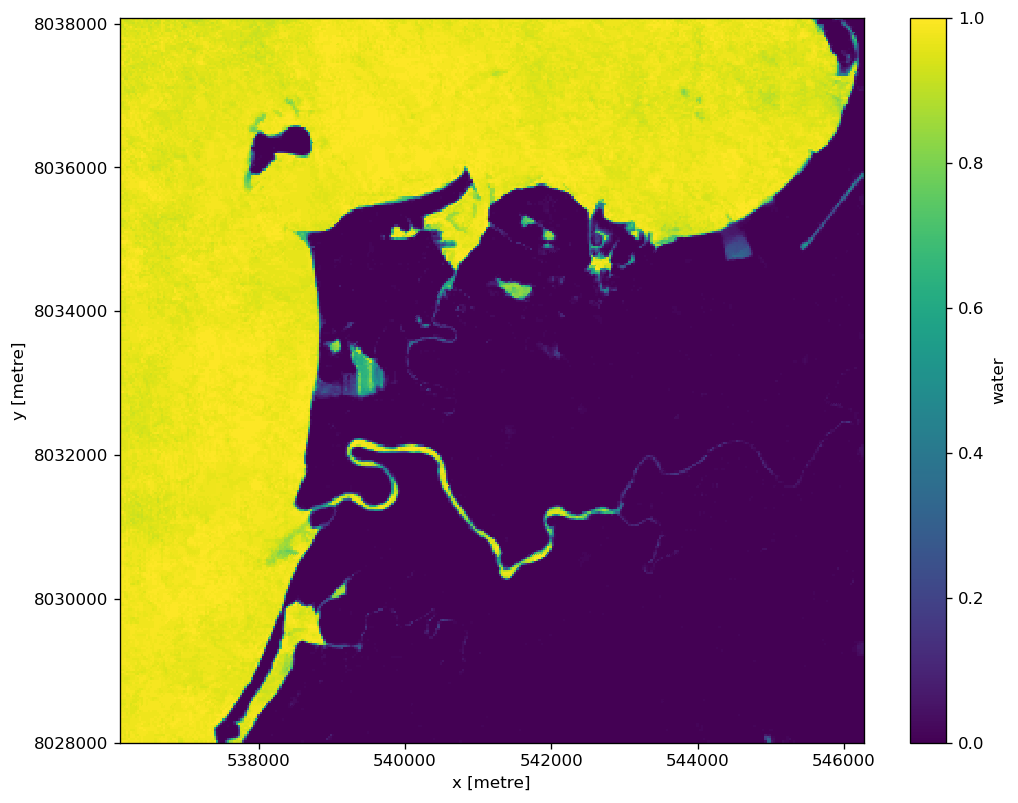

In [32]:
plt.figure(figsize = (10,8), dpi=120)
merged.water.mean(dim = 'time').plot();

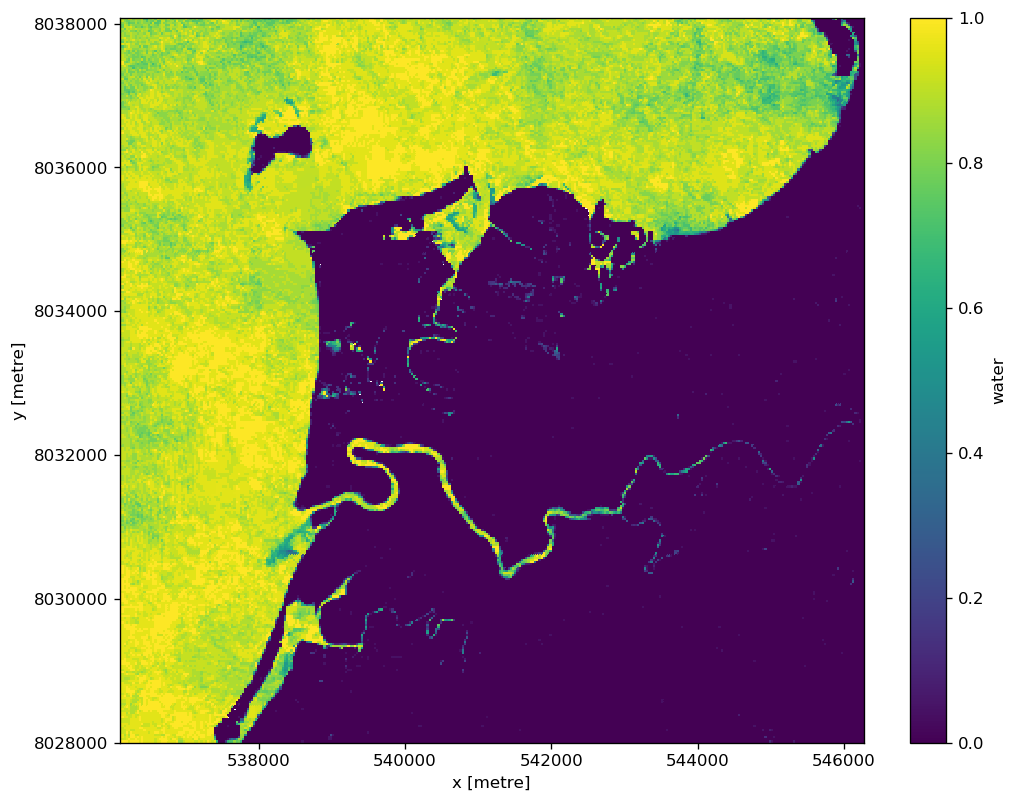

In [33]:
plt.figure(figsize = (10,8), dpi=120)
waterS2_comp.water.mean(dim = 'time').plot();

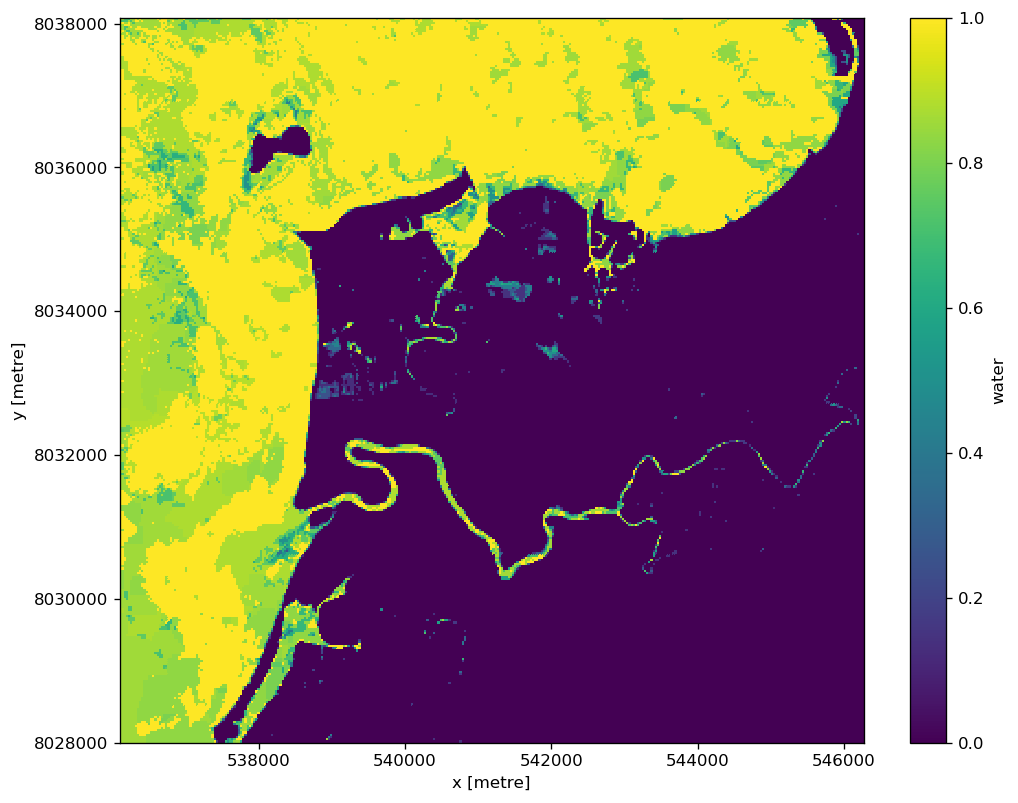

In [34]:
plt.figure(figsize = (10,8), dpi=120)
waterL8_comp.water.mean(dim = 'time').plot();